In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import json
#from sklearn.model_selection import train_test_split
#import torch
#from torch import nn, optim
import time
import beta_neuron as an

## Connectome Data

In [2]:
# Import connectome data

gapjn = {}
chemical = {}

# Gap Junction
gap_csv = pd.read_csv("gapjn.csv").fillna(0)
gap_data = gap_csv.values[:, 1:]
gap_labels = gap_csv.values[:, 0]

for i, label in enumerate(gap_labels):
    row_dict = {}
    for j, tag in enumerate(gap_labels):
        row_dict[tag] = gap_data[i, j]

    gapjn[label] = row_dict

# Chemical 
chem_csv = pd.read_csv("chemical.csv").fillna(0)
chem_data = chem_csv.values[:, 1:]
chem_labels = chem_csv.values[:, 0]
chem_cols = chem_csv.columns[1:]

for i, label in enumerate(chem_labels):
    row_dict = {}
    for j, tag in enumerate(chem_cols):
        row_dict[tag] = chem_data[i, j]

    chemical[label] = row_dict

## Connected sections

In [3]:
queue = {'PDA'}
visited = set()

while len(queue) > 0:

    neuron = queue.pop()

    if neuron not in chemical or neuron not in gapjn:
        continue
    
    visited.add(neuron)
    
    syn = {key for key in chemical[neuron] if chemical[neuron][key] != 0}
    gap = {} # {key for key in gapjn[neuron] if gapjn[neuron][key] != 0}

    comb = syn.union(gap)
    comb = comb.difference(visited)

    queue = queue.union(comb)
    

len(visited)

278

## Live Imaging Data

In [4]:
# Import neuron data

with open("data/2022-08-02-01.json", "r") as file:
    data_text = file.read()
    data_dict = json.loads(data_text)
    neuron = np.array(data_dict["trace_array"])

## Neuron Info (from Worm Atlas)

In [5]:
with open("neuron_table.json", "r") as file:
    neuron_info = json.load(file)

# Model

In [6]:
labels = list(visited)
labels.sort()
big_V = np.array([-35.0 for i in labels])
G_syn = []
G_gapjn = []

for i, to_cell in enumerate(labels):
    G_syn.append([])
    G_gapjn.append([])
    for j, from_cell in enumerate(labels):
        syn_value = 100.0 if chemical[from_cell][to_cell] > 0 else 0.0
        G_syn[i].append(syn_value)

        gap_value = 100.0 if gapjn[from_cell][to_cell] > 0 else 0.0
        G_gapjn[i].append(gap_value)

G_syn = np.array(G_syn)
G_gapjn = np.array(G_gapjn)

In [7]:
net = an.NeuronNetwork(big_V, G_syn, G_gapjn)

In [8]:
net.simple_run(0.01, 0.5)

##########

In [9]:
net.report()

V_max = -2.015775834804595 (163)


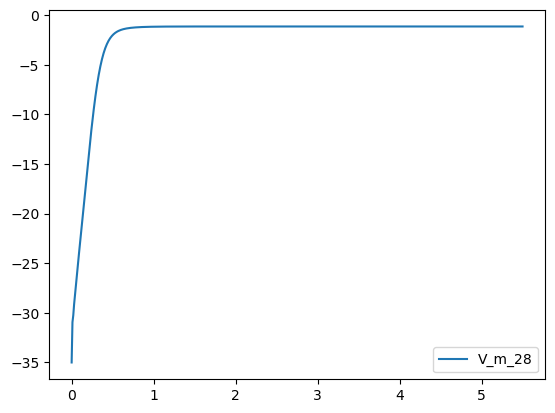

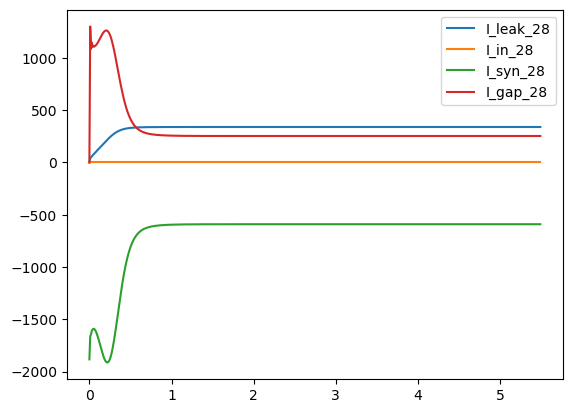

In [15]:
net.show_data(28)